# Get data

In [3]:
import requests
import xml.etree.ElementTree as ET

In [4]:
def get_urls(sitemap_url: str = "https://www.krasanamiru.cz/product-sitemap.xml") -> list[str]:
    """
    Extract product URLs from XML sitemap.
    
    Args:
        sitemap_url: URL of the XML sitemap
        
    Returns:
        List of product URLs
    """
    try:
        print(f"🔍 Fetching sitemap: {sitemap_url}")
        response = requests.get(sitemap_url, timeout=30)
        response.raise_for_status()
        
        # Parse XML
        root = ET.fromstring(response.content)
        
        # Handle namespace (common in sitemaps)
        namespace = {'ns': 'http://www.sitemaps.org/schemas/sitemap/0.9'}
        
        # Extract URLs
        urls = []
        for url_element in root.findall('.//ns:url', namespace):
            loc_element = url_element.find('ns:loc', namespace)
            if loc_element is not None:
                urls.append(loc_element.text)
        
        # Fallback: try without namespace
        if not urls:
            for url_element in root.findall('.//url'):
                loc_element = url_element.find('loc')
                if loc_element is not None:
                    urls.append(loc_element.text)
        
        print(f"✅ Found {len(urls)} URLs in sitemap")
        return urls
        
    except Exception as e:
        print(f"❌ Error fetching sitemap: {e}")
        return []

In [5]:
urls = get_urls()

🔍 Fetching sitemap: https://www.krasanamiru.cz/product-sitemap.xml
✅ Found 661 URLs in sitemap


In [12]:
url = 'https://www.krasanamiru.cz/produkty/kompaktni-bronzujici-pudr-golden-caramel/'
url in urls

True

In [14]:
with open('product_urls.txt', 'w') as f:
    f.write('\n'.join(map(str, urls)))

# Data in dataframe

In [34]:
import pandas as pd

In [35]:
df = pd.read_csv('df.csv')

In [46]:
df.head(5)

,Unnamed: 0,url,category,volume,purpose,description,suitable_for,how_to_use,ingredients,price
0,0,https://www.krasanamiru.cz/produkty/108855-2/,"['AKCE', 'Kompletní letní péče: na den a noc']",150.0,NaN,Naše kosmetička Martina pro Vás sestavila komp...,NaN,NaN,INGREDIENTS: viz jednotlivé produkty,NaN
1,1,https://www.krasanamiru.cz/produkty/anti-aging...,"['BIOEARTH', 'Jednorázové celulózové masky', '...",15.0,"['HYDRATUJE', 'OMLAZUJE', 'ZJEMŇUJE', 'VYHLAZU...",Jednorázová buněčná pleťová maska s kyselinou ...,"všechny typy pleti, ideální pro unavenou, pova...",masku aplikujte na důkladně vyčištěný a suchý ...,"INGREDIENTS:Aqua (WATER), Propanediol, ALOE BA...",220.0
2,2,https://www.krasanamiru.cz/produkty/24hod-krem...,"['BIOEARTH', 'Péče o pleť', 'Vitaminica', '24h...",50.0,"['ROZJASŇUJE', 'ZPEVŇUJE', 'ANTI-AGE', 'CHRÁNÍ']",Lehký krém s konzistencí fluidu bohatý na stab...,NaN,Naneste na čistou tvář a krk (ráno/večer viz. ...,"Aqua (WATER), Glyceryl Stearate SE, Caprylic/c...",669.0
3,3,https://www.krasanamiru.cz/produkty/balonek-pu...,"['BEAUTIFUL BROWS', 'LIFTING ŘAS', 'Balónek / ...",NaN,NaN,Balónek na vysoušení řas je speciálně navržen ...,NaN,NaN,NaN,NaN
4,4,https://www.krasanamiru.cz/produkty/antioxidac...,"['BIOEARTH', 'Šampony', 'Antioxidační šampon p...",250.0,"['REMINERALIZUJE', 'ČISTÍ', 'CHRÁNÍ', 'OSVĚŽUJE']",Remineralizující (znovu dodá minerály) šampon ...,všechny typy vlasů,NaN,"Aqua (Water), Ammonium Lauryl Sulfate, Cocamid...",369.0


In [37]:
from collections import Counter
import ast

def analyze_list_column(df, column_name):
    """Analyze a column containing lists of strings"""
    print(f"\n=== {column_name.upper()} ANALYSIS ===")
    
    # Flatten all lists into a single list
    all_values = []
    for item_list in df[column_name].dropna():
        item_list = ast.literal_eval(item_list)
        all_values.extend(item_list)
    
    # Count frequencies
    value_counts = Counter(all_values)
    
    print(f"Total unique {column_name} values: {len(value_counts)}")
    print(f"Total {column_name} instances: {sum(value_counts.values())}")
    print(f"Average {column_name} per product: {sum(value_counts.values()) / len(df):.2f}")
    
    # Most common values
    print(f"\nTop 15 most common {column_name}:")
    for value, count in value_counts.most_common(15):
        percentage = (count / sum(value_counts.values())) * 100
        print(f"  {value}: {count} ({percentage:.1f}%)")
    
    # Least common values (appearing only once)
    rare_values = [value for value, count in value_counts.items() if count == 1]
    print(f"\nValues appearing only once: {len(rare_values)}")
    if len(rare_values) <= 10:
        print(f"  {rare_values}")
    else:
        print(f"  Examples: {rare_values[:10]}...")
    
    return value_counts

In [44]:
# def recommendation_bot_insights(category_counts, purpose_counts):
def recommendation_bot_insights(purpose_counts):
    """Analyze data suitability for recommendation bot"""
    print("\n=== RECOMMENDATION BOT INSIGHTS ===")
    
    # Coverage analysis
    # total_categories = len(category_counts)
    total_purposes = len(purpose_counts)
    
    # High-frequency items (appear in >5% of products)
    # cat_threshold = sum(category_counts.values()) * 0.05
    pur_threshold = sum(purpose_counts.values()) * 0.05
    
    # frequent_categories = [cat for cat, count in category_counts.items() if count >= cat_threshold]
    frequent_purposes = [pur for pur, count in purpose_counts.items() if count >= pur_threshold]
    
    # print(f"Categories appearing in >5% of products: {len(frequent_categories)}")
    print(f"Purposes appearing in >5% of products: {len(frequent_purposes)}")
    
    # Recommendation potential
    print(f"\nRecommendation Bot Suitability:")
    # print(f"✓ Category diversity: {total_categories} unique categories")
    print(f"✓ Purpose diversity: {total_purposes} unique purposes")
    
    # if len(frequent_categories) >= 10:
    #     print(f"✓ Good category coverage: {len(frequent_categories)} frequent categories")
    # else:
    #     print(f"⚠ Limited category coverage: only {len(frequent_categories)} frequent categories")
    
    if len(frequent_purposes) >= 15:
        print(f"✓ Good purpose coverage: {len(frequent_purposes)} frequent purposes")
    else:
        print(f"⚠ Limited purpose coverage: only {len(frequent_purposes)} frequent purposes")
    
    # Data quality insights
    # rare_cat_pct = (len([c for c, count in category_counts.items() if count == 1]) / total_categories) * 100
    rare_pur_pct = (len([p for p, count in purpose_counts.items() if count == 1]) / total_purposes) * 100
    
    print(f"\nData Quality:")
    # print(f"Categories appearing only once: {rare_cat_pct:.1f}% (potential noise)")
    print(f"Purposes appearing only once: {rare_pur_pct:.1f}% (potential noise)")

In [41]:
import matplotlib.pyplot as plt

# def create_visualization(category_counts, purpose_counts):
def create_visualization( purpose_counts):
    """Create visualizations of the data"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Top categories
    # top_cats = dict(category_counts.most_common(15))
    # ax1.barh(range(len(top_cats)), list(top_cats.values()))
    # ax1.set_yticks(range(len(top_cats)))
    # ax1.set_yticklabels(list(top_cats.keys()), fontsize=8)
    # ax1.set_title('Top 15 Categories')
    # ax1.set_xlabel('Frequency')
    
    # Top purposes
    top_purs = dict(purpose_counts.most_common(15))
    ax2.barh(range(len(top_purs)), list(top_purs.values()))
    ax2.set_yticks(range(len(top_purs)))
    ax2.set_yticklabels(list(top_purs.keys()), fontsize=8)
    ax2.set_title('Top 15 Purposes')
    ax2.set_xlabel('Frequency')
    
    # Category frequency distribution
    # cat_freq_dist = Counter(category_counts.values())
    # ax3.bar(cat_freq_dist.keys(), cat_freq_dist.values())
    # ax3.set_title('Category Frequency Distribution')
    # ax3.set_xlabel('Times a category appears')
    # ax3.set_ylabel('Number of categories')
    # ax3.set_yscale('log')
    
    # Purpose frequency distribution
    pur_freq_dist = Counter(purpose_counts.values())
    ax4.bar(pur_freq_dist.keys(), pur_freq_dist.values())
    ax4.set_title('Purpose Frequency Distribution')
    ax4.set_xlabel('Times a purpose appears')
    ax4.set_ylabel('Number of purposes')
    ax4.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

In [42]:
def analyze_recommendation_data(df):
    """Complete analysis for recommendation bot data"""
    
    # Analyze both columns
    category_counts = analyze_list_column(df, 'category')
    purpose_counts = analyze_list_column(df, 'purpose')
    
    # Recommendation insights
    recommendation_bot_insights(purpose_counts)
    
    # Create visualizations
    create_visualization(purpose_counts)
    
    # Return data for further analysis
    return {
        'category_counts': category_counts,
        'purpose_counts': purpose_counts,
        'total_products': len(df)
    }

In [23]:
import ast

def create_feature_matrix(df):
    """Create binary feature matrix where each category/purpose is a separate feature"""
    
    # Get all unique features (individual elements)
    all_categories = set()
    all_purposes = set()
    
    for cat_list in df['category'].dropna():
        cat_list = ast.literal_eval(cat_list)
        if isinstance(cat_list, list):
            all_categories.update(cat_list)
    
    for pur_list in df['purpose'].dropna():
        pur_list = ast.literal_eval(pur_list)
        if isinstance(pur_list, list):
            all_purposes.update(pur_list)
    
    print(f"\nFeature Matrix for Recommendations:")
    print(f"Unique category features: {len(all_categories)}")
    print(f"Unique purpose features: {len(all_purposes)}")
    print(f"Total binary features: {len(all_categories) + len(all_purposes)}")
    
    # Create binary feature matrix
    feature_names = list(all_categories) + list(all_purposes)
    feature_matrix = pd.DataFrame(0, index=df.index, columns=feature_names)
    
    # Fill matrix
    for idx, row in df.iterrows():
        if pd.notna(row['category']):
            cat_list = ast.literal_eval(row['category'])
            if isinstance(cat_list, list):
                for cat in cat_list:
                    if cat in feature_matrix.columns:
                        feature_matrix.loc[idx, cat] = 1
        
        if pd.notna(row['purpose']):
            pur_list = ast.literal_eval(row['purpose'])
            if isinstance(pur_list, list):
                for pur in pur_list:
                    if pur in feature_matrix.columns:
                        feature_matrix.loc[idx, pur] = 1
    
    # Feature selection recommendations
    feature_usage = feature_matrix.sum().sort_values(ascending=False)
    frequent_features = feature_usage[feature_usage >= 3].index.tolist()
    
    print(f"Features appearing ≥3 times: {len(frequent_features)}")
    print(f"Sparse features (≤2 times): {len(feature_usage) - len(frequent_features)}")
    
    return feature_matrix, frequent_features


=== CATEGORY ANALYSIS ===
Total unique category values: 512
Total category instances: 1459
Average category per product: 3.19

Top 15 most common category:
  BIOEARTH: 193 (13.2%)
  BEAUTIFUL BROWS: 99 (6.8%)
  KRIPA: 91 (6.2%)
  Péče o pleť: 56 (3.8%)
  LIFTING ŘAS: 36 (2.5%)
  Vitaminica: 29 (2.0%)
  BARVY NA ŘASY & OBOČÍ: 28 (1.9%)
  TVÁŘ: 28 (1.9%)
  NATUREMMA: 26 (1.8%)
  Líčení: 26 (1.8%)
  Elementa - péče na míru: 25 (1.7%)
  Šampony: 21 (1.4%)
  AKCE: 19 (1.3%)
  OČI: 19 (1.3%)
  LOOM - Šnečí extrakt: 17 (1.2%)

Values appearing only once: 444
  Examples: ['Kompletní letní péče: na den a noc', 'Anti-aging maska s kyselinou hyaluronovou', '24hod. krém s vitamínem C a Amlou', 'Balónek / pumpička na vysoušení řas', 'Antioxidační šampon pro všechny typy vlasů', 'Balíček pro muže: tvář a tělo', 'Balzám na rty s kys. hyaluronovou', 'Balzám na rty se šípkovým olejem', 'Barva na řasy a obočí Intenzivní černá', 'Barva na řasy a obočí Modro černá']...

=== PURPOSE ANALYSIS ===
Total uni

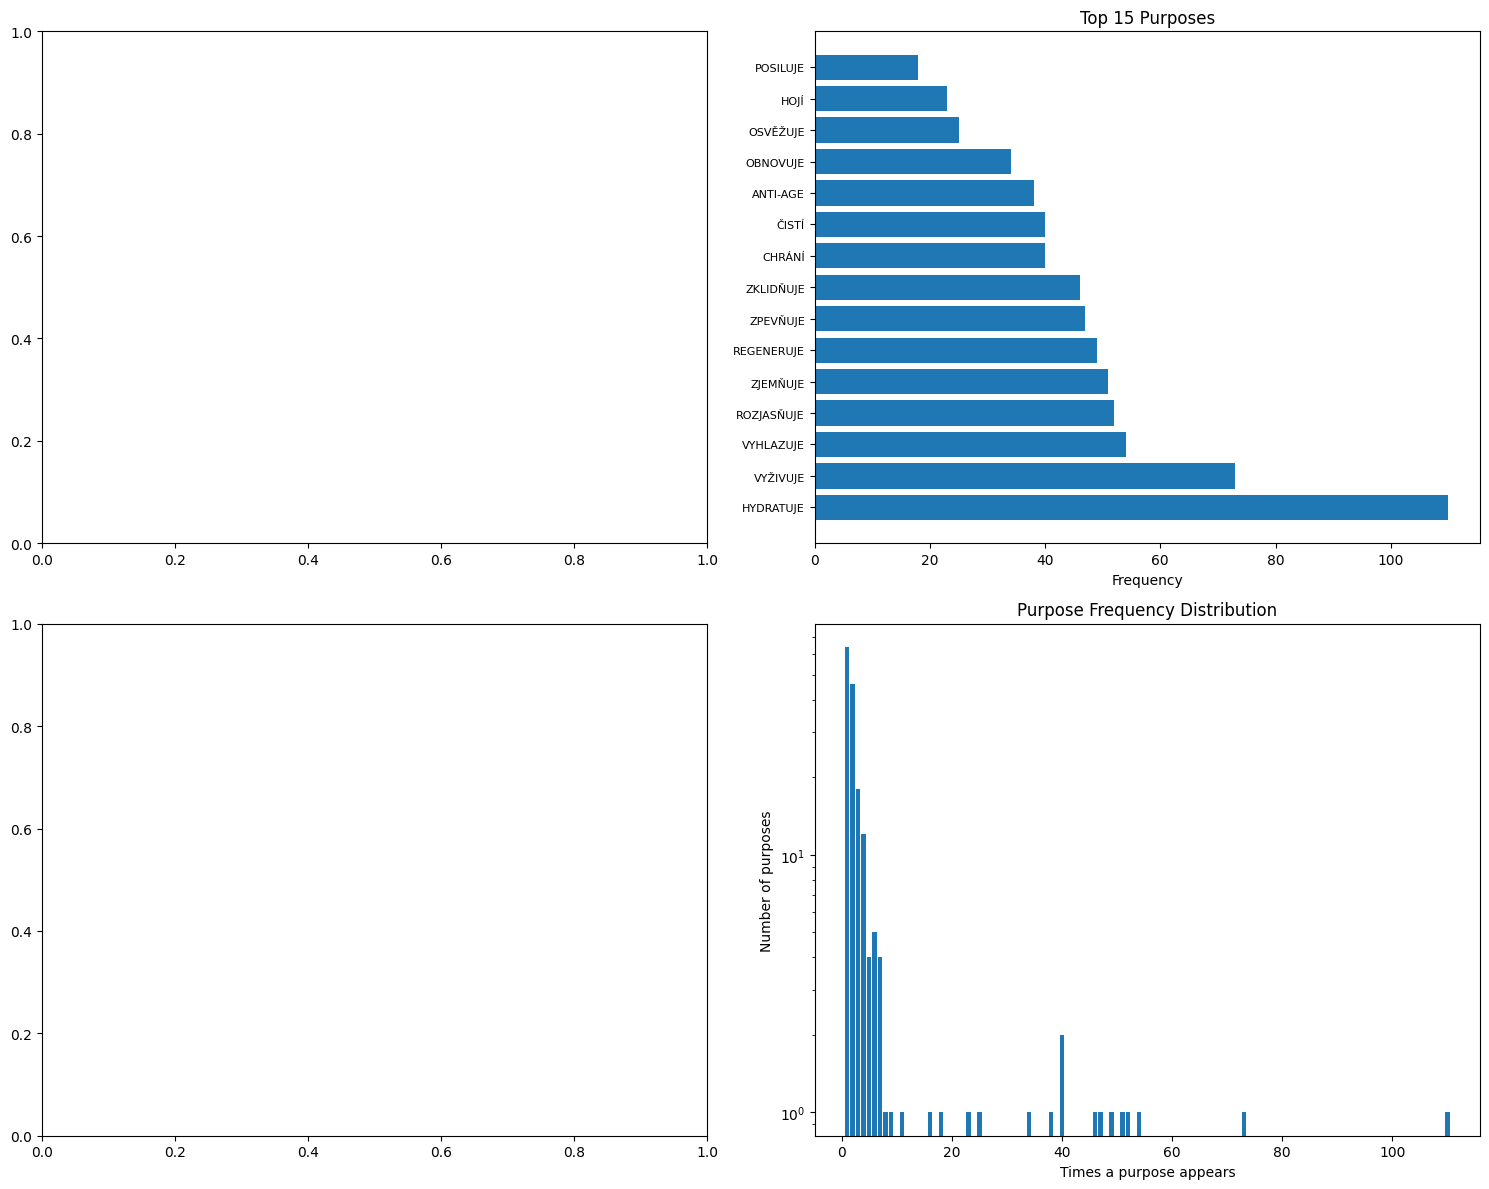

{'category_counts': Counter({'BIOEARTH': 193,
          'BEAUTIFUL BROWS': 99,
          'KRIPA': 91,
          'Péče o pleť': 56,
          'LIFTING ŘAS': 36,
          'Vitaminica': 29,
          'BARVY NA ŘASY & OBOČÍ': 28,
          'TVÁŘ': 28,
          'NATUREMMA': 26,
          'Líčení': 26,
          'Elementa - péče na míru': 25,
          'Šampony': 21,
          'AKCE': 19,
          'OČI': 19,
          'LOOM - Šnečí extrakt': 17,
          'EPIGENETICKÁ PÉČE': 16,
          'Péče tělo & ruce': 15,
          'POUKAZY': 12,
          'BIOprotettiva - šípkový olej': 11,
          'DEPILACE - VOSK': 11,
          'Výhodné balíčky': 11,
          'Masky a séra na vlasy': 11,
          'Sluneční péče': 11,
          'ŠTĚTCE': 10,
          'Jednorázové celulózové masky': 9,
          'Pro Muže': 8,
          'NÁHRADNÍ PRODUKTY': 8,
          'Kondicionéry': 8,
          'na opalování': 8,
          'Vzorky líčení': 8,
          'PUDRY NA BARVENÍ OBOČÍ': 7,
          'Oční stíny 

In [45]:
analyze_recommendation_data(df)

In [24]:
feature_matrix, frequent_features = create_feature_matrix(df)


Feature Matrix for Recommendations:
Unique category features: 113
Unique purpose features: 60
Total binary features: 173
Features appearing ≥3 times: 40
Sparse features (≤2 times): 133


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_matrix(feature_matrix, top_n=500):
    """Plot the binary feature matrix"""
    
    # 1. Heatmap of top features
    feature_counts = feature_matrix.sum().sort_values(ascending=False)
    top_features = feature_counts.head(top_n).index
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(feature_matrix[top_features].T, 
                cmap='Blues', cbar=True, xticklabels=False)
    plt.title(f'Top {top_n} Features Heatmap')
    plt.ylabel('Features')
    plt.xlabel('Products')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 2. Feature frequency bar chart
    plt.figure(figsize=(12, 6))
    top_20 = feature_counts.head(20)
    plt.barh(range(len(top_20)), top_20.values)
    plt.yticks(range(len(top_20)), top_20.index, fontsize=9)
    plt.xlabel('Frequency')
    plt.title('Top 20 Most Common Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # 3. Feature sparsity visualization
    plt.figure(figsize=(10, 6))
    sparsity_per_product = (feature_matrix == 0).sum(axis=1)
    plt.hist(sparsity_per_product, bins=30, alpha=0.7)
    plt.xlabel('Number of Zero Features per Product')
    plt.ylabel('Number of Products')
    plt.title('Feature Sparsity Distribution')
    plt.show()
    
    # 4. Co-occurrence matrix (top features only)
    top_10_features = feature_counts.head(10).index
    cooccurrence = feature_matrix[top_10_features].T.dot(feature_matrix[top_10_features])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence, annot=True, fmt='d', 
                xticklabels=top_10_features, yticklabels=top_10_features)
    plt.title('Feature Co-occurrence Matrix (Top 10)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

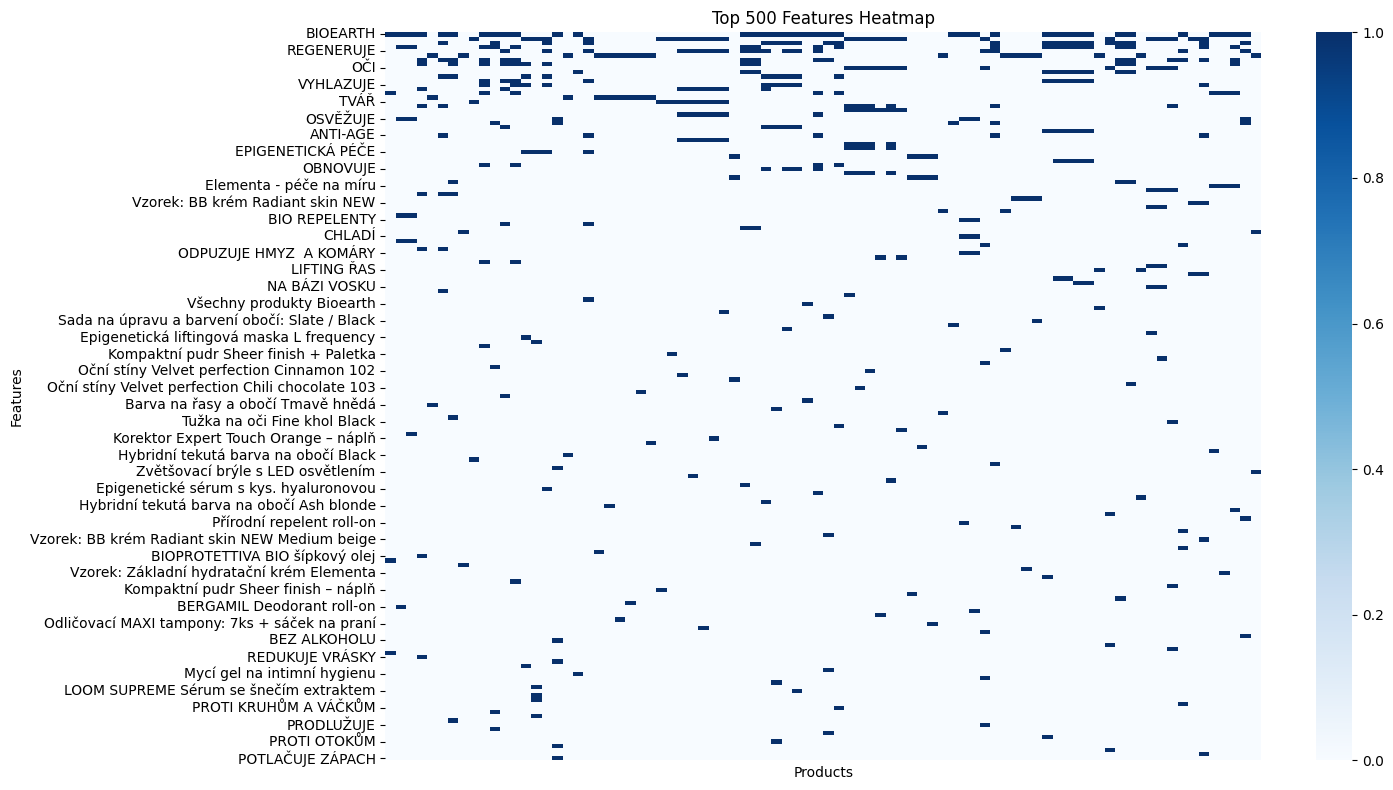

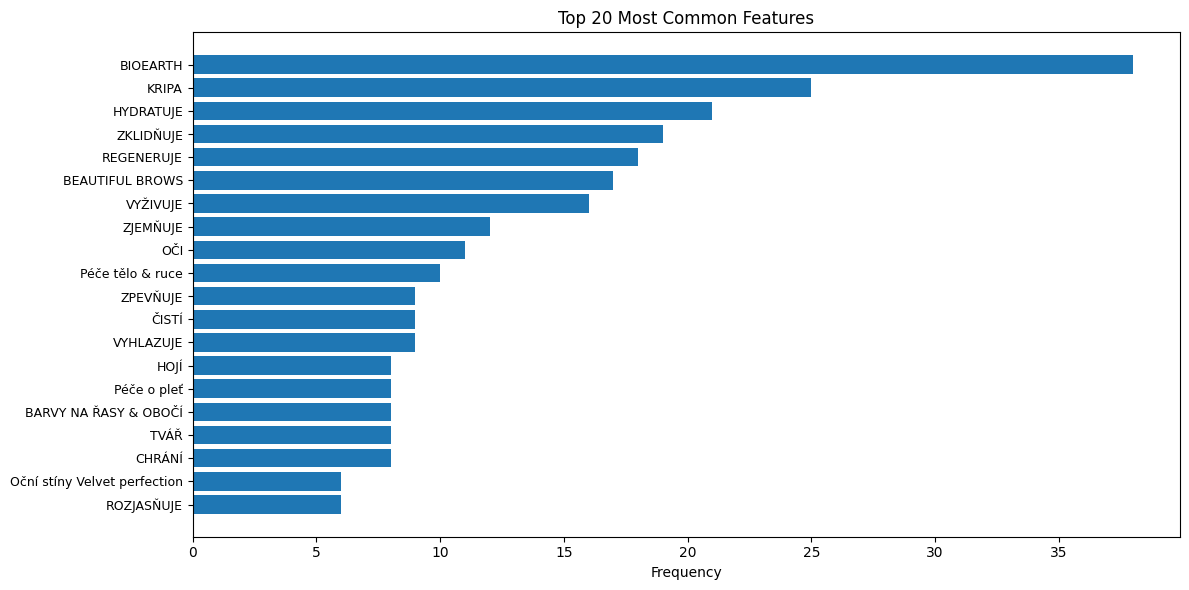

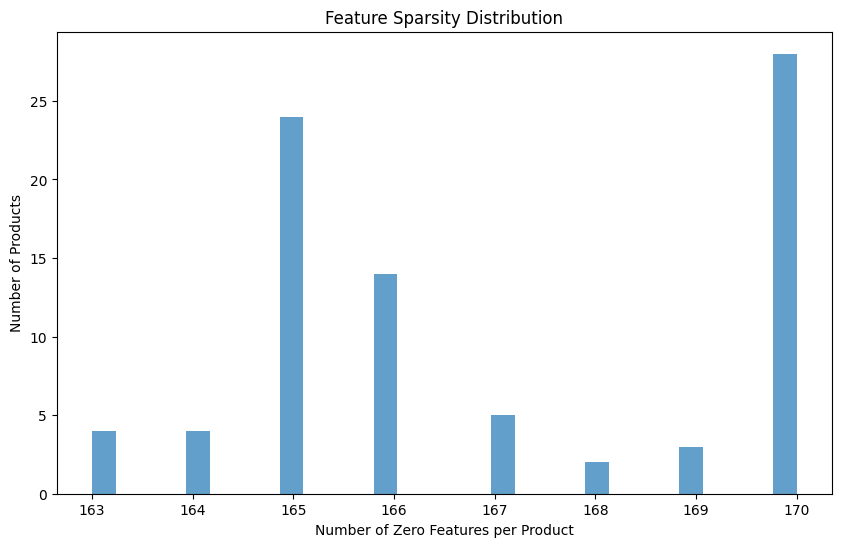

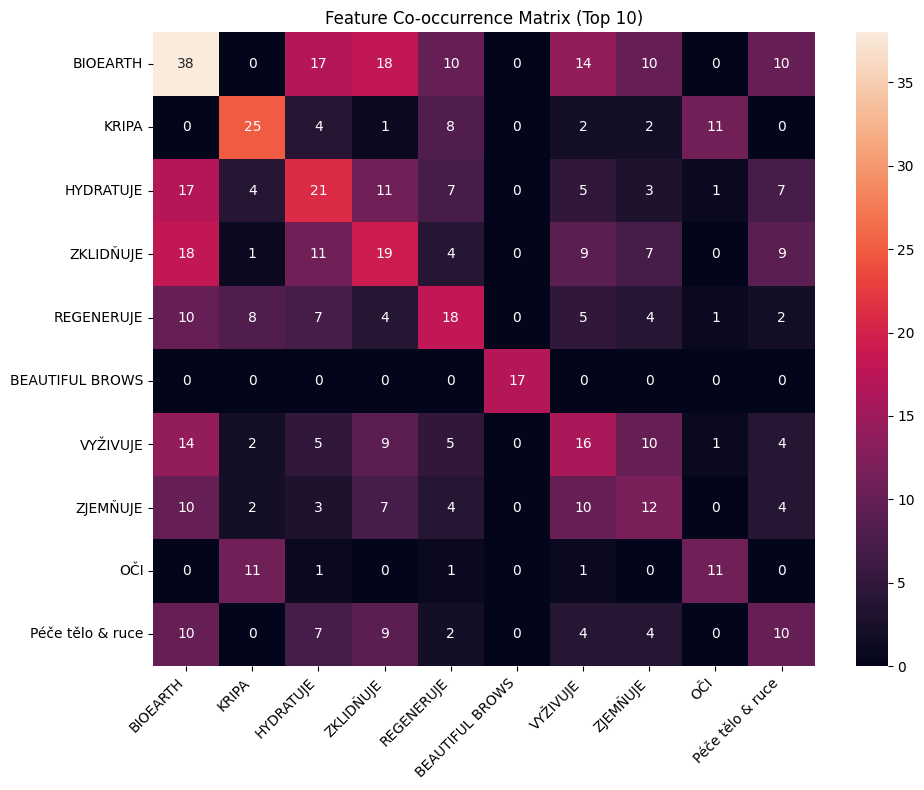

In [28]:
plot_feature_matrix(feature_matrix)

In [47]:
df_1 = df.copy()

In [48]:
df_1['category'] = df_1['category'].apply(lambda x: ast.literal_eval(x)[1:] if pd.notna(x) and x != '' else x)

In [49]:
df_1

,Unnamed: 0,url,category,volume,purpose,description,suitable_for,how_to_use,ingredients,price
0,0,https://www.krasanamiru.cz/produkty/108855-2/,[Kompletní letní péče: na den a noc],150.0,NaN,Naše kosmetička Martina pro Vás sestavila komp...,NaN,NaN,INGREDIENTS: viz jednotlivé produkty,NaN
1,1,https://www.krasanamiru.cz/produkty/anti-aging...,"[Jednorázové celulózové masky, Anti-aging mask...",15.0,"['HYDRATUJE', 'OMLAZUJE', 'ZJEMŇUJE', 'VYHLAZU...",Jednorázová buněčná pleťová maska s kyselinou ...,"všechny typy pleti, ideální pro unavenou, pova...",masku aplikujte na důkladně vyčištěný a suchý ...,"INGREDIENTS:Aqua (WATER), Propanediol, ALOE BA...",220.0
2,2,https://www.krasanamiru.cz/produkty/24hod-krem...,"[Péče o pleť, Vitaminica, 24hod. krém s vitamí...",50.0,"['ROZJASŇUJE', 'ZPEVŇUJE', 'ANTI-AGE', 'CHRÁNÍ']",Lehký krém s konzistencí fluidu bohatý na stab...,NaN,Naneste na čistou tvář a krk (ráno/večer viz. ...,"Aqua (WATER), Glyceryl Stearate SE, Caprylic/c...",669.0
3,3,https://www.krasanamiru.cz/produkty/balonek-pu...,"[LIFTING ŘAS, Balónek / pumpička na vysoušení ...",NaN,NaN,Balónek na vysoušení řas je speciálně navržen ...,NaN,NaN,NaN,NaN
4,4,https://www.krasanamiru.cz/produkty/antioxidac...,"[Šampony, Antioxidační šampon pro všechny typy...",250.0,"['REMINERALIZUJE', 'ČISTÍ', 'CHRÁNÍ', 'OSVĚŽUJE']",Remineralizující (znovu dodá minerály) šampon ...,všechny typy vlasů,NaN,"Aqua (Water), Ammonium Lauryl Sulfate, Cocamid...",369.0
...,...,...,...,...,...,...,...,...,...,...
452,452,https://www.krasanamiru.cz/produkty/zkoseny-st...,"[LIFTING ŘAS, Zkosený štětec na obočí s kartáč...",NaN,NaN,Praktický DUO štětec určený k barvení řas a ob...,NaN,NaN,NaN,390.0
453,453,https://www.krasanamiru.cz/produkty/zkoseny-st...,"[BARVY NA ŘASY & OBOČÍ, Zkosený štětec střední]",NaN,NaN,"Tento štěteček je ideální pro hustší obočí, pr...",NaN,NaN,NaN,120.0
454,454,https://www.krasanamiru.cz/produkty/zmatnujici...,"[Líčení, Zmatňující kompaktní pudr Neutral beige]",NaN,"['ZMATŇUJE', 'ROZJASŇUJE', 'ZJEMŇUJE', 'SJEDNO...",Hedvábný kompaktní pudr s vysoce kvalitními př...,NaN,"Nanášejte štětcem na tvář, krk. Lze použít sam...","INGREDIENTS: MICA, Glyceryl Behenate, Caprylic...",650.0
455,455,https://www.krasanamiru.cz/produkty/zpevnujici...,"[Pleťová séra, Zpevňující tonizační sérum se š...",5.0,"['HYDRATUJE', 'ROZJASŇUJE', 'ZPEVŇUJE', 'SJEDN...",SÉRUM = 7denní INTENZIVNÍ KÚRAPleťové sérum bo...,"všechny typy pleti, ideální pro suchou, dehydr...",na čistý obličej naneste několik kapek séra a ...,"Aqua (WATER), Snail Secretion Filtrate, ALOE B...",220.0


In [52]:
import ast

# Create new column from first elements
# df_1['cat'] = df_1['category'].apply(lambda x: ast.literal_eval(x)[0] if pd.notna(x) and x != '' else None)

def safe_first_element(x):
    # if pd.isna(x) or x == '':
    #     return None
    if isinstance(x, list):
        return x[0] if len(x) > 0 else None
    try:
        return ast.literal_eval(x)[0]
    except:
        return None

df_1['cat'] = df_1['category'].apply(safe_first_element)

In [54]:
df_1['cat'].value_counts()

cat
Péče o pleť                             56
LIFTING ŘAS                             36
BARVY NA ŘASY & OBOČÍ                   28
TVÁŘ                                    28
Líčení                                  26
                                        ..
Tištěný poukaz na 1500Kč                 1
Hydratační oleje                         1
Základní set hybridní barvy na obočí     1
Odlíčení & čištění                       1
Pleťová séra                             1
Name: count, Length: 61, dtype: int64